In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import json
import open3d as o3d
import copy
import triangle
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image
import imageio
import os
from tqdm import tqdm
import cv2
from scipy import signal
import numpy as np

In [2]:
depth = skio.imread("example_depth.png")
  
depth = sk.img_as_float(depth)[:,:,0]

In [38]:
colors = skio.imread("example_img.png")
  
colors = sk.img_as_float(colors)
colors = np.array(colors[:,:,:3])

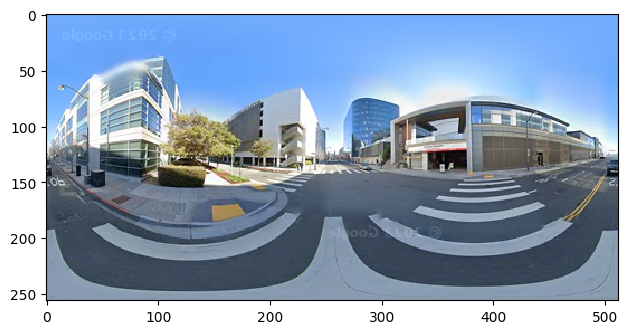

In [4]:
skio.imshow(colors)

In [5]:
print(depth.shape)

(256, 512)


In [6]:
h = 256
w = 512

In [52]:
def calculate_cart_coordinate(depth, rgb):
    points = []
    colors = []
    for i in range(h):
        for j in range(w):
            phi = (w-j-1)/(w-1) * 2* 3.14159 + 0.5*3.14159
            theta = (h-i-1)/(h-1) * 3.14159
            
            v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

            if depth[i,j] < 1e7:
                points.append(copy.copy(v*depth[i,j]*255))
                colors.append(rgb[i, j])
                
    return points, colors
            

In [23]:
def calculate_cart_coordinate_populate(depth):
    points = []
    selected_index = []
    for i in range(h):
        for j in range(w):
            for offset_i in np.linspace(-0.5, 0.5, 5):
                for offset_j in np.linspace(-0.5, 0.5, 5):
                    w_sample = w + 0.5
                    h_sample = h + 0.5
                    phi = (w_sample-(j+offset_j)-1)/(w_sample-1) * 2* 3.14159 + 0.5*3.14159
                    theta = (h_sample-(i+offset_i)-1)/(h_sample-1) * 3.14159
                    
                    v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), -np.cos(theta)])
                    
                    if depth[i,j] < 1e7:
                        points.append(copy.copy(v*depth[i,j]))
                        selected_index.append(i*w + j)
    return points, selected_index
            

In [30]:
def calculate_cart_coordinate_random(depth, n_samples=10):
    points = []
    selected_index = []
    for i in range(h):
        for j in range(w):
            for _ in range(n_samples):
                w_sample = w + 0.5
                h_sample = h + 0.5
                offset_j, offset_i = np.random.uniform(-0.5, 0.5, 2)
                phi = (w_sample-(j+offset_j)-1)/(w_sample-1) * 2* 3.14159 + 0.5*3.14159
                theta = (h_sample-(i+offset_i)-1)/(h_sample-1) * 3.14159
                
                v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), -np.cos(theta)])
                
                if depth[i,j] < 1e7:
                    points.append(copy.copy(v*depth[i,j]))
                    selected_index.append(i*w + j)
    return points, selected_index
            

array([-0.01111501])

In [71]:
def get_neighbors(shape, i, j):
    h, w = shape
    
    neighbors = []
    
    for off_i in range(-1, 2):
        for off_j in range(-1, 2):
            n_i, n_j = i + off_i, j + off_j # w, h
            
            if (n_j > 0 and n_j < w) and (n_i > 0 and n_i < h):
                neighbors.append([i, j])

    return neighbors

def sample_points_along_line(point1, point2, n, perturb=0.1):
    # Ensure the points have the same shape
    assert point1.shape == point2.shape, "Points must have the same shape"

    # Create an array of shape (n, len(point1)) with values between 0 and 1
    t_values = np.linspace(0, 1, n)[:, np.newaxis] + np.random.uniform(-perturb, perturb, n)[:, np.newaxis]

    # Linearly interpolate between the two points
    interpolated_points = (1 - t_values) * point1 + t_values * point2

    return interpolated_points

def calculate_cart_coordinate_interpolate(depth, rgb, n_samples=2):
    points = []
    colors = []

    for i in range(h):
        for j in range(w):
            w_sample = w + 0.5
            h_sample = h + 0.5
            offset_j, offset_i = np.random.uniform(-0.5, 0.5, 2)
            phi = (w_sample-(j+offset_j)-1)/(w_sample-1) * 2* 3.14159 + 0.5*3.14159
            theta = (h_sample-(i+offset_i)-1)/(h_sample-1) * 3.14159
            
            if depth[i,j] < 1:
                v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), -np.cos(theta)]) * depth[i, j]
                
                rgb_v = rgb[i, j]
                
                points.append(copy.copy(v))
                colors.append(rgb_v)
                
                for n in get_neighbors(depth.shape, i, j):
                    n_i, n_j = n

                    phi = (w_sample-(n_j)-1)/(w_sample-1) * 2* 3.14159 + 0.5*3.14159
                    theta = (h_sample-(n_i)-1)/(h_sample-1) * 3.14159
                    
                    if depth[n_i,n_j] < 1:
                        u = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), -np.cos(theta)]) * depth[n_i,n_j]
                        rgb_u = rgb[n_i, n_j]
                        
                        samples = sample_points_along_line(u, v, n_samples)
                        
                        l_uv = np.linalg.norm(u - v)
                        for pt in samples:
                            alpha = np.linalg.norm(pt - u) / l_uv
                            rgb_n = rgb_v * alpha + rgb_u * (1 - alpha)
                            
                            points.append(copy.copy(u))
                            colors.append(rgb_n)
                    
                    
                
    return points, colors
            

In [72]:
points, rgbs = calculate_cart_coordinate_interpolate(depth, colors, n_samples=3)

In [53]:
points, rgbs = calculate_cart_coordinate(depth, colors)

In [74]:
# Define a list of points (replace this with your own coordinates)
points = np.array(points)
# Create a point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(rgbs)


# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud])

In [75]:
point_cloud.estimate_normals()

In [76]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        point_cloud, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 2376440 / 41438
[Open3D DEBUG] #   Got kernel density: 0.0228288 (s), 1635.51 (MB) / 1635.51 (MB) / 3538 (MB)
[Open3D DEBUG] #     Got normal field: 0.136001 (s), 1651.98 (MB) / 1651.98 (MB) / 3538 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.945621e-07 / 7.000092e-01
[Open3D DEBUG] #       Finalized tree: 0.195555 (s), 1675.76 (MB) / 1675.76 (MB) / 3538 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.275812 (s), 1632.96 (MB) / 1675.76 (MB) / 3538 (MB)
[Open3D DEBUG] #Set point constraints: 0.0390270 (s), 1633.86 (MB) / 1675.76 (MB) / 3538 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 853322 / 975224 / 1
[Open3D DEBUG] Memory Usage: 1633.867 MB
Cycle[0] Depth[0/9]:	[Open3D DEBUG] # Linear system solved: 0.734111 (s), 1649.22 (MB) / 1675.76 (MB) / 3538 (MB)
[Open3D DEBUG] Got average: 0.018852 (s), 1608.73 (MB) / 1675.76 (MB) / 3538 (MB)
[Open3D DEBUG] Iso-Value: 4.982704e-01 = 1.184110e+06 / 